# Commodity Trend Barometer

### Extract Norgate Commodity Price data and calculate multiple Technical Indicators over various time frames and determine the strength of a trend by aggregating these indicators    

In [4]:
import norgatedata
import requests
import talib
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import wraps
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from matplotlib.dates import MO, AutoDateLocator, WeekdayLocator, MonthLocator


### Timing decorator that will show how long the various functions take to run

In [5]:
def timethis(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        r = func(*args, **kwargs)
        end = time.perf_counter()
        print('{}.{} : {} milliseconds'.format(func.__module__, func.__name__, (end - start)*1e3))
        return r
    return wrapper

### List of Continuous Commodity Futures contracts (backadjusted) in the Norgate Database

In [6]:
tickers = [
	'&6A_CCB', # AUD
    '&6B_CCB', # GBP
	'&6C_CCB', # CAD
    '&6E_CCB', # EUR
    '&6J_CCB', # JPY
    '&6M_CCB', # MXN
    '&6N_CCB', # NZD
    '&6S_CCB', # CHF
    '&AFB_CCB', # Eastern Australia Feed Barley
    '&AWM_CCB', # Eastern Australia Wheat
   	'&BAX_CCB', # Canadian Bankers Acceptance
    '&BRN_CCB', # Brent Crude Oil
 	'&BTC_CCB', # Bitcoin 
    '&CC_CCB', # Cocoa 
    '&CGB_CCB', # Canadian 10 Yr Govt Bond 
    '&CL_CCB', # Crude Oil - Light Sweet
    '&CT_CCB', # Cotton #2
    '&DC_CCB', # Milk - Class III
    '&DX_CCB', # US Dollar Index
    '&EH_CCB', # Ethanol
    '&EMD_CCB', # S&P MidCap 400 E-mini
    '&ES_CCB', # S&P 500 E-mini
    '&FBTP_CCB', # Euro-BTP Long Term
    '&FCE_CCB', # CAC 40
    '&FDAX_CCB', # DAX
    '&FESX_CCB', # EURO STOXX 50
    '&FGBL_CCB', # Euro-Bund - 10 Yr
    '&FGBM_CCB', # Euro-Bobl - 5 Yr
    '&FGBS_CCB', # Euro-Schatz - 2 Yr
    '&FGBX_CCB', # Euro-Buxl - 30 Yr
    '&FSMI_CCB', # Swiss Market Index
    '&FTDX_CCB', # TecDAX
    '&GAS_CCB', # Gas Oil
    '&GC_CCB', # Gold
    '&GD_CCB', # GS&P GSCI
    '&GE_CCB', # Eurodollar
    '&GF_CCB', # Feeder Cattle    
    '&HE_CCB', # Lean Hogs    
    '&HG_CCB', # Copper    
    '&HO_CCB', # NY Harbor ULSD     
    '&HSI_CCB', # Hang Seng Index     
    '&KC_CCB', # Coffee C
    '&KE_CCB', # KC HRW Wheat
    '&KOS_CCB', # KOSPI 200
    '&LBS_CCB', # Lumber
	'&LCC_CCB', # London Cocoa
    '&LE_CCB', # Live Cattle
    '&LES_CCB', # Euro Swiss
    '&LEU_CCB', # Euribor
    '&LFT_CCB', # FTSE 100
    '&LLG_CCB', # Long Gilt
    '&LRC_CCB', # Robusta Coffee
    '&LSS_CCB', # Short Sterling
    '&LSU_CCB', # White Sugar
    '&LWB_CCB', # Feed Wheat
    '&MHI_CCB', # Hang Seng Index - Mini
    '&MWE_CCB', # Hard Red Spring Wheat
    '&NG_CCB', # Henry Hub Natural Gas
    '&NIY_CCB', # Nikkei 225 Dollar    
    '&NKD_CCB', # Nikkei 225 Dollar
    '&NQ_CCB', # Nasdaq-100 - E-mini
    '&OJ_CCB', # Frozen Concentrated Orange Juice
    '&PA_CCB', # Palladium
    '&PL_CCB', # Platinum
    '&RB_CCB', # RBOB Gasoline
    '&RS_CCB', # Canola
    '&RTY_CCB', # Russell 2000 - E-mini
    '&SB_CCB', # Sugar No. 11
    '&SCN_CCB', # FTSE China A50 Index
    '&SI_CCB', # Silver
    '&SIN_CCB', # SGX Nifty 50 Index
    '&SJB_CCB', # Japanese Govt Bond - Mini
    '&SNK_CCB', # Nikkei 225 (SGX)
    '&SP_CCB', # S&P 500
    '&SSG_CCB', # MSCI Singapore Index
    '&STW_CCB', # MSCI Taiwan Index
    '&SXF_CCB', # S&P/TSX 60 Index
    '&TN_CCB', # Ultra 10 Year U.S. T-Note
    '&UB_CCB', # Ultra U.S. T-Bond
    '&VX_CCB', # Cboe Volatility Index    
    '&WBS_CCB', # WTI Crude Oil
    '&YAP_CCB', # ASX SPI 200
    '&YG_CCB', # Gold - Mini
    '&YI_CCB', # Silver - Mini
    '&YIB_CCB', # ASX 30 Day Interbank Cash Rate
    '&YIR_CCB', # ASX 30 Day Interbank Cash Rate
    '&YM_CCB', # E-mini Dow
    '&YXT_CCB', # ASX 10 Year Treasury Bond
    '&YYT_CCB', # ASX 3 Year Treasury Bond
    '&ZB_CCB', # U.S. T-Bond
    '&ZC_CCB', # Corn
    '&ZF_CCB', # 5-Year US T-Note
    '&ZG_CCB', # Gold 100oz
    '&ZI_CCB', # Silver 5000oz
    '&ZL_CCB', # Soybean Oil
    '&ZM_CCB', # Soybean Meal
    '&ZN_CCB', # 10-Year US T-Note    
    '&ZO_CCB', # Oats
    '&ZQ_CCB', # 30 Day Federal Funds
    '&ZR_CCB', # Rough Rice
    '&ZS_CCB', # Soybeans    
    '&ZT_CCB', # 2-Year US T-Note    
    '&ZW_CCB', # Chicago SRW Wheat
           ]

### Function to import data for a given list of tickers and history window, returning a dictionary of pandas dataframes (one for each ticker) and a dictionary of the security names associated with each ticker

In [7]:
@timethis
def import_data_norgate(tickers, lookback):
    # Create empty dictionaries
    ticker_dict = {}
    ticker_name_dict = {}
    ticker_short_name_dict = {}

    # Loop through list of tickers
    for ticker in tickers:
        # Append 'c_' to each ticker to avoid labels starting with a number and create lowercase value
        tick = "c_"+ticker[1:]
        lowtick = tick.lower()

        # Set data format and extract each DataFrame, storing as a key-value pair in ticker_dict 
        timeseriesformat = 'pandas-dataframe'
        ticker_dict[lowtick] = norgatedata.price_timeseries(ticker, limit = lookback, format=timeseriesformat,)

        # Extract the security name and store in ticker_name_dict
        ticker_name = norgatedata.security_name(ticker)
        ticker_name_dict[lowtick] = ticker_name

        # Truncate the ticker name to improve charting legibility and store in ticker_short_name_dict 
        ticker_short_name_dict[lowtick] = ticker_name.replace('Continuous Futures Backadjusted','')

    return ticker_dict, ticker_name_dict, ticker_short_name_dict

### Lists of parameter values for each of the indicators to be calculated

In [8]:
df_ma_list = [10, 20, 30, 50, 200]
df_macd_params = [12, 26, 9]
df_adx_list = [14, 20, 50, 200]
df_ma_cross_list = [[10, 30], [20, 50], [50, 200]]
df_price_cross_list = [20, 50, 200]
df_rsi_list = [14]
df_atr_list = [14]

### Function to add Moving Average, MACD, ADX, RSI, ATR indicators and trend flags too each dataframe based on whether shorter MA is above longer MA, price is above MA, ADX is above 25 and MACD Histogram is increasing

In [15]:
@timethis
def create_fields(ticker_dict, ma_list=df_ma_list, macd_params=df_macd_params, adx_list=df_adx_list, 
                  ma_cross_list=df_ma_cross_list, price_cross_list=df_price_cross_list, 
                  rsi_list=df_rsi_list , atr_list=df_atr_list):        

    # Loop through each ticker in ticker_dict
    for ticker, df in ticker_dict.items():
        # Create moving averages of 10, 20, 30, 50 and 200 day timeframes
        for tenor in ma_list:
            df['MA_'+str(tenor)] = df['Close'].rolling(window=str(tenor)+'D').mean()


        # Create MACD, Signal and Hist using default parameters of 12, 26, 9
        df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = talib.MACD(df['Close'], fastperiod=macd_params[0], slowperiod=macd_params[1], signalperiod=macd_params[2])
        # Create flag for MACD histogram increasing 
        df['MACD_flag'] = np.where(df['MACD_HIST'].diff() > 0, 1, 0)


        # Create ADX of 14, 20, 50 and 200 day timeframes 
        # Create flags for ADX over 25 for 20, 50 and 200 day timeframes
        for tenor in adx_list:
            df['ADX_'+str(tenor)] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=tenor)
            df['ADX_'+str(tenor)+'_flag'] = np.where(df['ADX_'+str(tenor)] > 25, 1, 0)


        # Create flag for fast moving average crossing slow moving average
        for tenor_pair in ma_cross_list:
            df['MA_'+str(tenor_pair[0])+'_'+str(tenor_pair[1])] = np.where(df['MA_'+str(tenor_pair[0])] > df['MA_'+str(tenor_pair[1])], 1, 0)


        # Create flag for price crossing moving average
        for tenor in price_cross_list:
            df['PX_MA_'+str(tenor)] = np.where(df['Close'] > df['MA_'+str(tenor)], 1, 0)


        # Create RSI with 14 day timeframe 
        for tenor in rsi_list:
            df['RSI_'+str(tenor)] = talib.RSI(df['Close'], timeperiod=tenor)

        # Create Average True Range with 14 day timeframe
        for tenor in atr_list:
            df['ATR_'+str(tenor)] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=tenor)


    return ticker_dict

### List of trend flags to compare, ordered from short term to long term 

In [10]:
trend_flags = ['MA_10_30',
               'MACD_flag',               
               'PX_MA_20',
               'MA_20_50',
               'ADX_20_flag',
               'PX_MA_50',
               'MA_50_200',
               'ADX_50_flag',
               'PX_MA_200',
               'ADX_200_flag']

### Function to create new dataframe showing the strength of trend that the indicators are showing for each of the markets

In [11]:
@timethis
def create_barometer(ticker_dict, ticker_name_dict, trend_flags):
    
    # Create list of tickers from ticker_dict
    ticker_list = [ticker for ticker, df in ticker_dict.items()]

    # Convert ticker_name_dict to DataFrame 
    ticker_name_df = pd.DataFrame.from_dict(ticker_name_dict, orient='index', columns=['Long_name']) 

    # Create empty DataFrame with Trend Flags as columns and tickers as rows
    frame = pd.DataFrame(columns = trend_flags, index = ticker_list)

    # Merge the two DataFrames
    frame = pd.merge(frame, ticker_name_df, left_index=True, right_index=True)

    # Reorder columns with list of column names moving the Long Name to the start 
    cols = [frame.columns[-1]] + [col for col in frame if col != frame.columns[-1]]
    frame = frame[cols]

    # Loop through each ticker in ticker_dict to populate trend flags in frame
    for ticker, df in ticker_dict.items():
        for flag in trend_flags:
            frame.loc[ticker, flag] = df[flag].iloc[-1]

    # Create trend strength column that sums the trend flags and sort by this column       
    frame['Trend Strength'] = frame.iloc[:,1:].sum(axis=1)
    frame = frame.sort_values(by=['Trend Strength'], ascending=False)

    # Create short name column, stripping text from longname 
    frame['Short_name'] = frame.loc[:,'Long_name'].str.replace('Continuous Futures Backadjusted','')

    return frame


### Trend Barometer using the list of tickers above

In [16]:
ticker_dict, ticker_name_dict, ticker_short_name_dict = import_data_norgate(tickers, 500)
ticker_dict = create_fields(ticker_dict)
barometer = create_barometer(ticker_dict, ticker_name_dict, trend_flags)

__main__.import_data_norgate : 4136.739100000341 milliseconds
__main__.create_fields : 1468.648399999438 milliseconds
__main__.create_barometer : 144.6513999999297 milliseconds


In [17]:
barometer.head(15)

,Long_name,MA_10_30,MACD_flag,PX_MA_20,MA_20_50,ADX_20_flag,PX_MA_50,MA_50_200,ADX_50_flag,PX_MA_200,ADX_200_flag,Trend Strength,Short_name
c_bax_ccb,Canadian Bankers Acceptance Continuous Futures...,1,1,1,1,1,1,1,1,1,1,10.0,Canadian Bankers Acceptance
c_6a_ccb,Australian Dollar Continuous Futures Backadjusted,1,1,1,1,1,1,1,0,1,0,8.0,Australian Dollar
c_zl_ccb,Soybean Oil Continuous Futures Backadjusted,1,1,1,1,1,1,1,0,1,0,8.0,Soybean Oil
c_yir_ccb,ASX 90 Day Bank Accepted Bills Continuous Futu...,1,1,0,1,1,1,1,1,1,0,8.0,ASX 90 Day Bank Accepted Bills
c_sin_ccb,SGX Nifty 50 Index Continuous Futures Backadju...,1,1,1,1,1,1,1,0,1,0,8.0,SGX Nifty 50 Index
c_nq_ccb,E-mini Nasdaq-100 Continuous Futures Backadjusted,1,1,1,1,1,1,1,0,1,0,8.0,E-mini Nasdaq-100
c_lss_ccb,Short Sterling Continuous Futures Backadjusted,1,1,1,1,1,1,1,0,1,0,8.0,Short Sterling
c_6b_ccb,British Pound Continuous Futures Backadjusted,1,1,1,1,1,1,1,0,1,0,8.0,British Pound
c_lbs_ccb,Random Length Lumber Continuous Futures Backad...,1,0,1,1,1,1,1,1,1,0,8.0,Random Length Lumber
c_es_ccb,E-mini S&P 500 Continuous Futures Backadjusted,1,1,1,1,1,1,1,0,1,0,8.0,E-mini S&P 500


### Function to create barchart of most / least trending markets

In [25]:
def trend_barchart(barometer=barometer, mkts=20, top=True):
    
    # Initialize the figure
    fig, ax = plt.subplots()

    # Set the xticks to be integer values
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Set the yticks to be horizontal
    plt.yticks(rotation=0)

    # If the markets flag is set to False, show the markets with lowest trend indication
    if top == False:
        plt.barh(barometer['Short_name'][-mkts:], barometer['Trend Strength'][-mkts:])

    # Otherwise show the markets with greatest trend indication 
    else:
        plt.barh(barometer['Short_name'][:mkts], barometer['Trend Strength'][:mkts])

    # Label xaxis
    plt.xlabel("Trend Strength") 

    plt.tight_layout()
    plt.show()


### Express the Top 20 results in a horizontal barchart

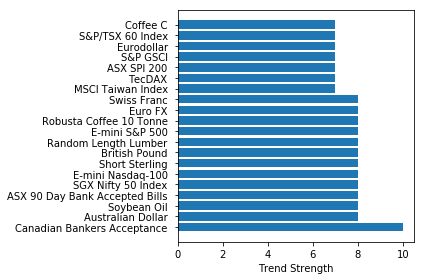

In [26]:
trend_barchart(mkts=20)

### And the Bottom 20

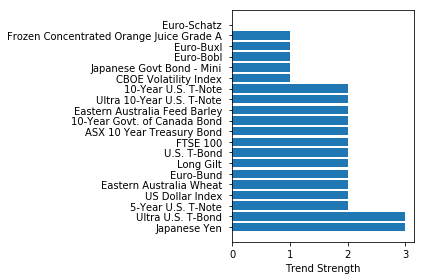

In [27]:
trend_barchart(mkts=20, top=False)

 ### Function to create list of Top and/or Bottom trending markets and new dataframe of the closing prices of these markets and forward fill prices to fill in any NaN values

In [28]:
def prepare_chart_data(barometer, ticker_dict, ticker_short_name_dict, mkts=5, up='Both'):
    
    # if trend flag is True, select tickers of most trending markets (twice 
    # as many as if selecting both)
    if up == True:
        data_list = list(barometer.index[:(mkts*2)])

    # if trend flag is False, select tickers of least trending markets        
    elif up == False:
        data_list = list(barometer.index[-(mkts*2):])

    # Otherwise select both
    else:    
        top = list(barometer.index[:mkts])
        bottom = list(barometer.index[-mkts:])
        data_list = top + bottom

    # Create a new DataFrame
    chart_data = pd.DataFrame()

    # For each ticker in the list of selected tickers, add the column of closing 
    # prices to new DataFrame
    for ticker in data_list:
        chart_data[ticker] = ticker_dict[ticker]['Close']

    # Rename columns from tickers to short names and forward fill any NaN cells
    chart_data = chart_data.rename(columns=ticker_short_name_dict)
    chart_data = chart_data.fillna(method='ffill')

    return chart_data, data_list

In [29]:
chart_data, data_list = prepare_chart_data(barometer, ticker_dict, ticker_short_name_dict, 5, 'Both')

### Function to normalize data histories to start from 100

In [30]:
def norm_hist(chart_data, days=60):
    
    # Copy the selected number of days history from the input DataFrame
    tenor = chart_data[-days:].copy()

    # Normalize the closing price of each ticker to start from 100 at the beginning of the history window
    for ticker in tenor.columns:
        tenor[ticker] = tenor[ticker].div(tenor[ticker].iloc[0]).mul(100) 

    return tenor  

### Normalized dataframes covering the past 1y, 6m and 3m

In [32]:
data_norm_3m = norm_hist(chart_data, 60) 
data_norm_6m = norm_hist(chart_data, 120) 
data_norm_1y = norm_hist(chart_data, 250)

### Function to graph returns

In [35]:
def return_graph(tenor):
    
    # Initialize the figure
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(16,8))

    # Plot the lineplot
    ax.plot(tenor)

    # axis formatting
    # create a variable to choose interval between xticks based on length of history
    week_scaler = int(round(len(tenor) / 30))
    month_scaler = int(round(len(tenor) / 120))

    # Set major xticks as every 4th Monday or monthly at a specified interval
    #major_tick = WeekdayLocator(byweekday=MO, interval = 4)
    scale_week_tick = WeekdayLocator(byweekday=MO, interval=week_scaler)
    scale_month_tick = MonthLocator(interval=month_scaler)
    #auto_date = AutoDateLocator(maxticks=6)

    # Set axis format as DD-MMM-YYYY or MMM-YYYY
    daysFmt = mdates.DateFormatter('%d-%b-%Y')
    monthsFmt = mdates.DateFormatter('%b-%Y')

    # If less than 90 days history use day format and locate major xticks on 4th Monday
    if len(tenor) < 90:
        ax.xaxis.set_major_formatter(daysFmt)
        ax.xaxis.set_major_locator(scale_week_tick)
        #ax.xaxis.set_major_locator(auto_date)
        #ax.xaxis.set_major_locator(major_tick)

    # Otherwise use month format and locate major xticks at monthly (or greater) intervals
    else:
        ax.xaxis.set_major_formatter(monthsFmt)
        ax.xaxis.set_major_locator(scale_month_tick)

    # Set minor xticks to be 4 within each major xtick
    minor_tick = AutoMinorLocator(4)
    ax.xaxis.set_minor_locator(minor_tick)

    # Set size of ticks
    ax.tick_params(which='both', width=1)
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

    # Set prices to the right as we are concerned with the current level
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()

    # Set the legend 
    plt.legend(loc='upper left', labels=tenor.columns)

    # Set xtick labels at 70 degrees
    plt.xticks(rotation=70)

    plt.tight_layout()
    plt.show()    


### 3 Month Returns of top and bottom 5 trending markets

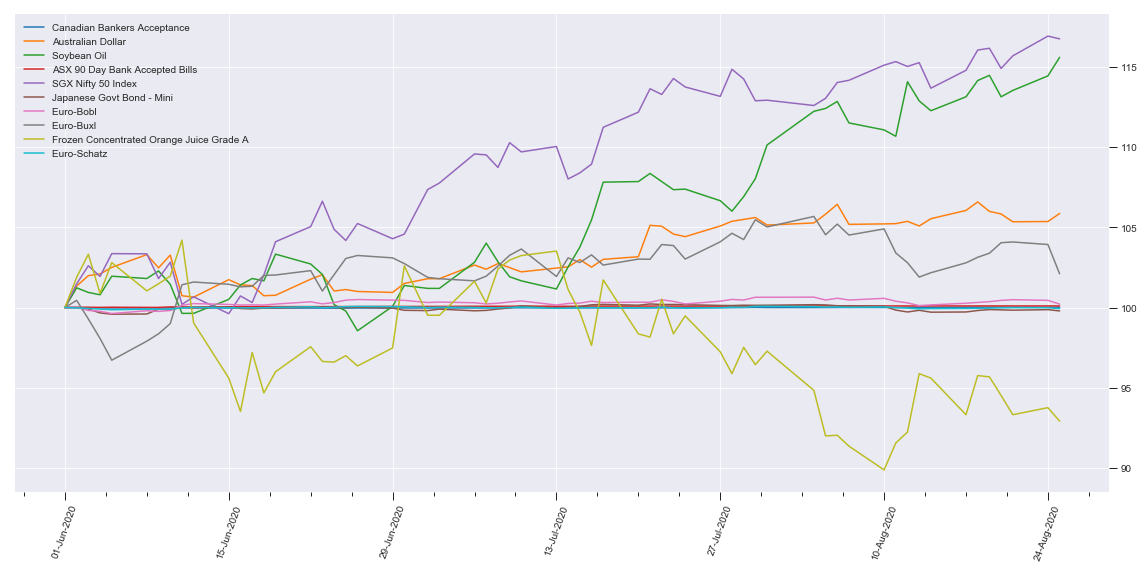

In [36]:
return_graph(data_norm_3m)

### 6 Month Returns of top and bottom 5 trending markets

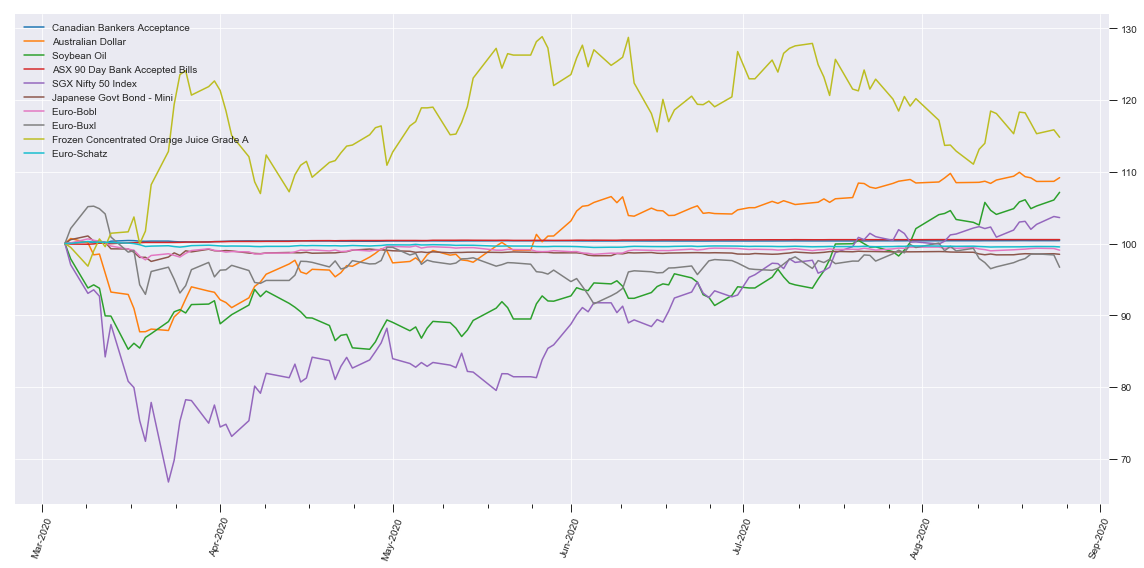

In [37]:
return_graph(data_norm_6m)

### 1 Year Returns of top and bottom 5 trending markets

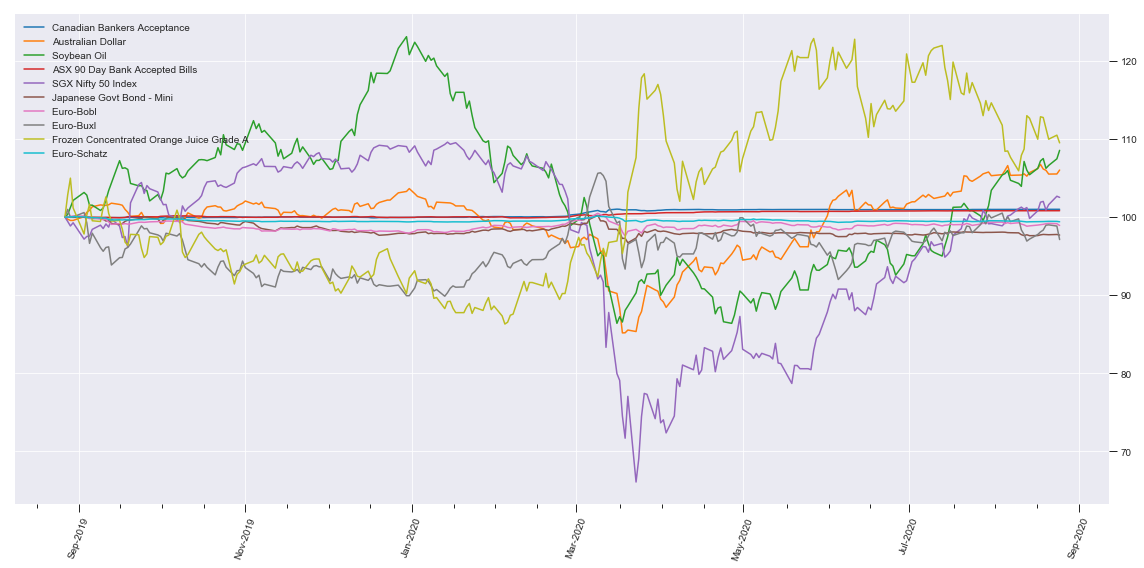

In [38]:
return_graph(data_norm_1y)

### Lets take a more granular look at the top and bottom 20

In [39]:
chart_data, data_list = prepare_chart_data(barometer, ticker_dict, ticker_short_name_dict, 20, 'Both')

### Function to plot comparison of 40 markets

In [43]:
def market_chart(ticker_dict, ticker_short_name_dict, data_list, days=60, norm=True): 
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(16,16))
    plt.tight_layout()
    plt.style.use('seaborn-darkgrid')

    # create a color palette
    palette = plt.get_cmap('tab20')

    # multiple line plot
    num=0
    for ticker in data_list:
        num += 1
        if num < 21:
            colr = num
        else:
            colr = num - 20

        label = ticker_short_name_dict[ticker]

        # Find the right spot on the plot
        ax = plt.subplot(8,5, num)

        # Plot the lineplot
        if norm == True:
            ax.plot(ticker_dict[ticker].index[-days:], 
                     ticker_dict[ticker]['Close'][-days:].div(ticker_dict[ticker]['Close'][-days:].iloc[0]).mul(100), 
                     marker='', 
                     color=palette(colr), 
                     linewidth=1.9, 
                     alpha=0.9, 
                     label=label)
        else:
            ax.plot(ticker_dict[ticker].index[-days:], 
                     ticker_dict[ticker]['Close'][-days:], 
                     marker='', 
                     color=palette(colr), 
                     linewidth=1.9, 
                     alpha=0.9, 
                     label=label)    

        # xticks only on bottom graphs
        if num in range(36) :
            plt.tick_params(labelbottom=False)

        # Add title
        plt.title(label, loc='left', fontsize=12, fontweight=0, color='black' )

        # axis formatting
        # create a variable to choose interval between xticks based on length of history
        week_scaler = int(round(days / 30))
        month_scaler = int(round(days / 120))

        # Set major xticks as every 4th Monday or monthly at a specified interval  
        #major_tick = WeekdayLocator(byweekday=MO, interval = 4)
        scale_week_tick = WeekdayLocator(byweekday=MO, interval=week_scaler)
        scale_month_tick = MonthLocator(interval=month_scaler)
        #auto_date = AutoDateLocator(maxticks=6)

        # Set axis format as DD-MMM-YYYY or MMM-YYYY
        daysFmt = mdates.DateFormatter('%d-%b-%Y')
        monthsFmt = mdates.DateFormatter('%b-%Y')

        # If less than 90 days history use day format and locate major xticks on 4th Monday
        if days < 90:
            ax.xaxis.set_major_formatter(daysFmt)
            #ax.xaxis.set_major_locator(auto_date)
            ax.xaxis.set_major_locator(scale_week_tick)
            #ax.xaxis.set_major_locator(major_tick)

        # Otherwise use month format and locate major xticks at monthly (or greater) intervals    
        else:
            ax.xaxis.set_major_formatter(monthsFmt)
            ax.xaxis.set_major_locator(scale_month_tick)

        # Set minor xticks to be 4 within each major xtick
        minor_tick = AutoMinorLocator(4)
        ax.xaxis.set_minor_locator(minor_tick)

        # Set size of ticks
        ax.tick_params(which='both', width=1)
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=4)

        # Set prices to the right as we are concerned with the current level
        ax.yaxis.set_label_position('right')
        ax.yaxis.tick_right()

        # Set xtick labels at 70 degrees
        plt.xticks(rotation=70)

    # general title
    plt.suptitle("Top and Bottom Trending Markets", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)


### 3m Returns for each of the top and bottom 20 trending markets

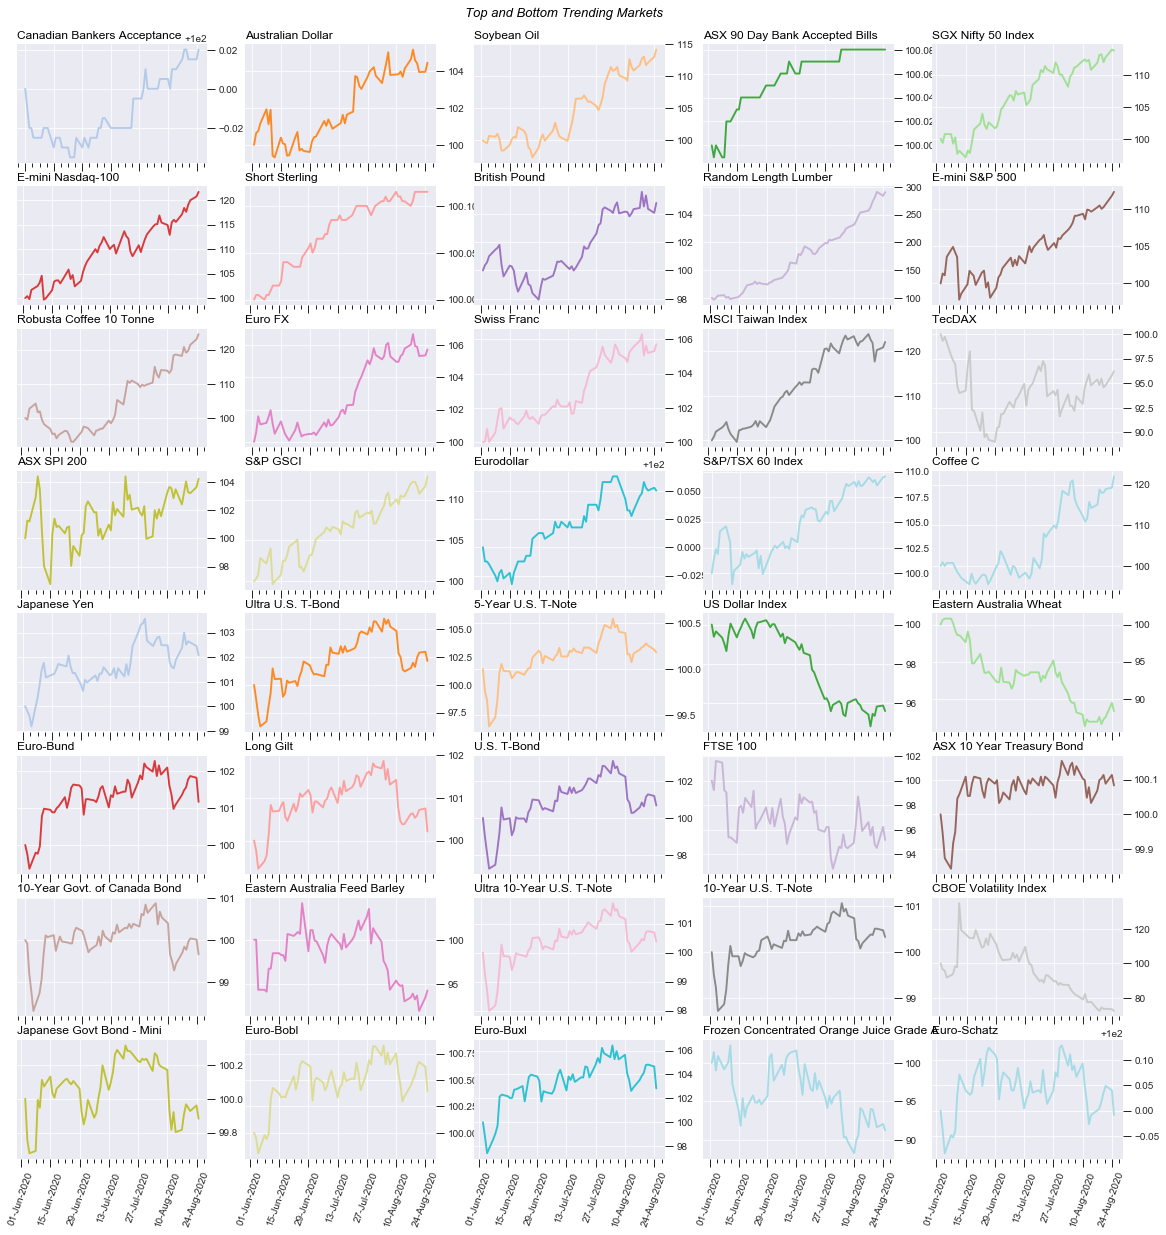

In [44]:
market_chart(ticker_dict, ticker_short_name_dict, data_list, 60, True)

### 1y Returns for each of the top and bottom 20 trending markets

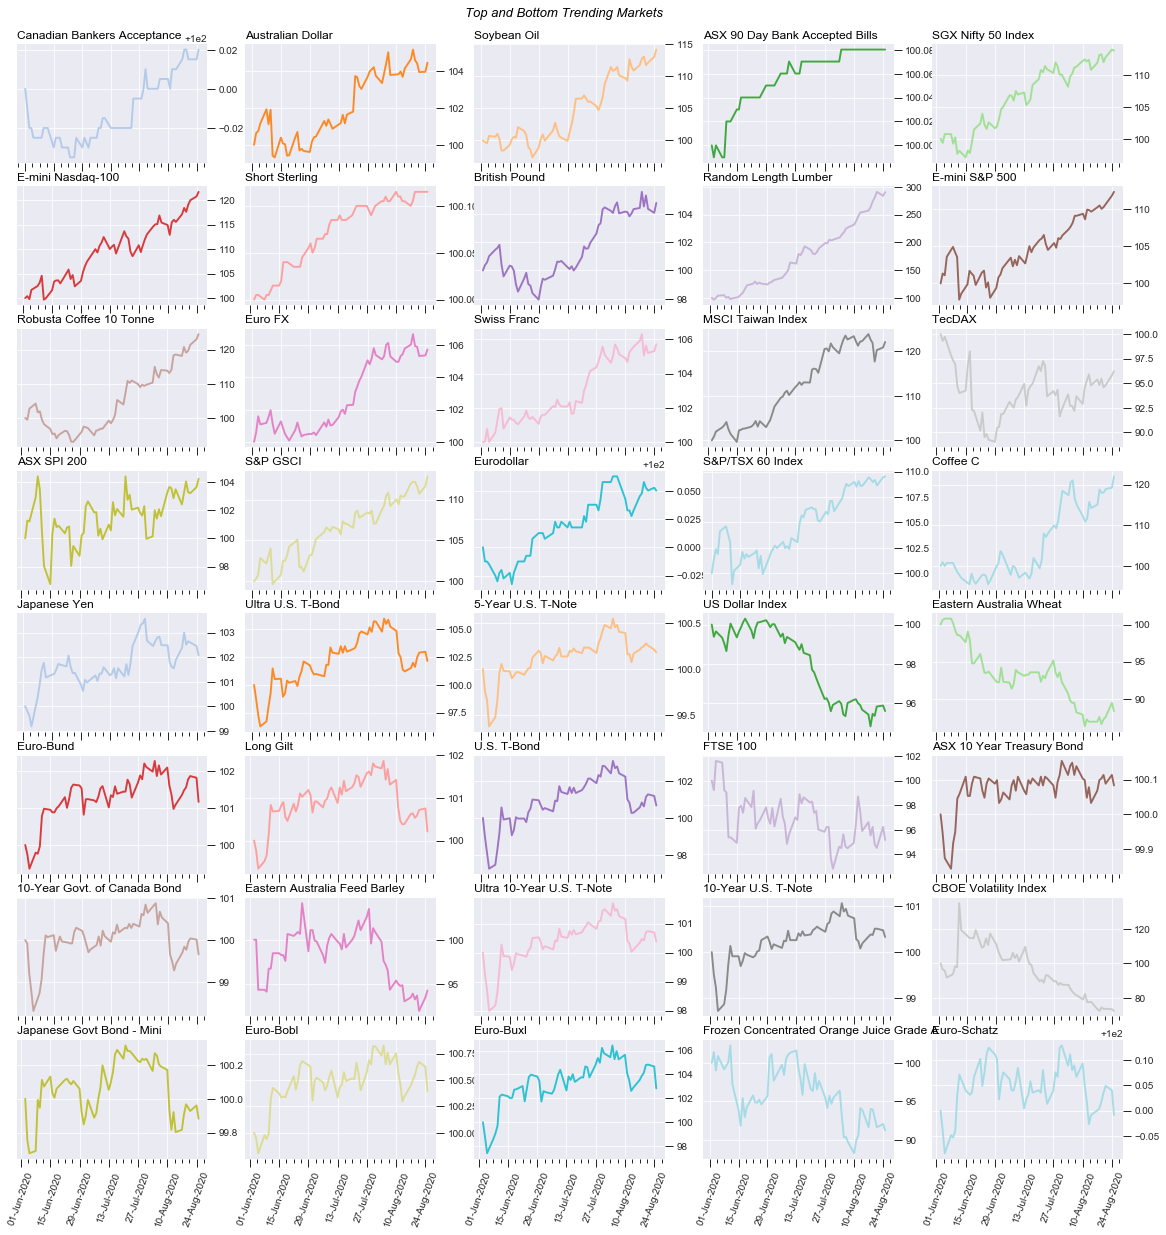

In [45]:
market_chart(ticker_dict, ticker_short_name_dict, data_list, 60, True)